# Fukushima

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

In [ ]:
#from spanda.data.transforms.kssl import (get_spectra_files, to_spectra, 
#                                         rand_w_avg, avg, snv, AnalytesTfm)


from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, Analytes, Spectra,
                                    DerivTfm, AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, TrimTfm,
                                    NormalizeTfm, LogTfm)


from pathlib import Path
from fastai.vision.all import *
from fastai.callback.hook import *
from fastai.data.all import *
from fastcore.parallel import parallel
from tqdm import tqdm

from mirzai.data.transform import TakeDerivative, SNV, DropSpectralRegions
from mirzai.vis.core import plot_spectra
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import kennard_stone as ks
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.stats import skew

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
# file getters
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

## PLSR

### Data preparation

In [ ]:
#analyte = 'kd_cs133'
#analyte = 'c'
#analyte = 'ex_cs_total_cs_ratio'
#analyte = 'ph'
#analyte = 'cs137_total'
analytes = ['kd_cs133', 'ex_cs_total_cs_ratio', 'cs137', 'cs137_total', 
            'ex_cs137', 'ex_k2o', 'ph', 'c', 'n', 'c_n_ratio', 'ex_mgo',
            'ex_cao', 'cec']
#analyte = 'cec'
path = Path('../../_data/seibersdorf-mirs')
X_names = np.arange(4000, 600, -2)

In [ ]:
torch.cuda.is_available()

False

In [ ]:
path.ls()

(#176) [Path('../../_data/seibersdorf-mirs/135'),Path('../../_data/seibersdorf-mirs/95'),Path('../../_data/seibersdorf-mirs/66'),Path('../../_data/seibersdorf-mirs/104'),Path('../../_data/seibersdorf-mirs/68'),Path('../../_data/seibersdorf-mirs/103'),Path('../../_data/seibersdorf-mirs/168'),Path('../../_data/seibersdorf-mirs/157'),Path('../../_data/seibersdorf-mirs/150'),Path('../../_data/seibersdorf-mirs/159')...]

In [ ]:
len([get_spectra(p) for p in path.ls()])

176

In [ ]:
#def is_valid(path, analytes=analytes):
#    is_analyte_pos = AnalytesTfm(analytes)(path).item() > 0
#    has_spectra = len(get_spectra_files(path)) > 0
#    return is_analyte_pos and has_spectra

In [ ]:
#%%time 
#paths_mask = parallel(is_valid, path.ls(), progress=True)

In [ ]:
#get_spectra_files(path.ls()[0])

(#4) [Path('../../_data/seibersdorf-mirs/135/135d.csv'),Path('../../_data/seibersdorf-mirs/135/135a.csv'),Path('../../_data/seibersdorf-mirs/135/135b.csv'),Path('../../_data/seibersdorf-mirs/135/135c.csv')]

In [ ]:
#to_spectra(get_spectra_files(path.ls()[0])).show(wn=X_names)

#### Generate tabular dataset

In [ ]:
n_smp = None # None for all
dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                   get_x=get_spectra,
                   get_y=get_target,
                   #splitter=RandomSplitter(),
                   #splitter=IndexSplitter(val_idx),
                   item_tfms=[AvgTfm(), TrimTfm(), SNVTfm()])

dls = dblock.dataloaders(path.ls()[:n_smp], bs=256, drop_last=False)

In [ ]:
dls.train.one_batch()[0].shape

torch.Size([141, 1, 1700])

In [ ]:
dls.valid.one_batch()[0].shape

torch.Size([35, 1, 1700])

In [ ]:
#x_tfms = [get_spectra_files, to_spectra, avg, snv]
#y_tfms = [AnalytesTfm(analytes=analytes)]

In [ ]:
#dsets = Datasets(path.ls(), [x_tfms, y_tfms])
#dls = dsets.dataloaders(bs=32, drop_last=False)
#dls.train.one_batch()[0].shape

In [ ]:
def asTabular(dls, n=1):
    xs, ys = [], []
    for i in range(n):
        for x, y in tqdm(dls):
            xs.append(x)
            ys.append(y)
    return (torch.cat(ds).squeeze().numpy() for ds in (xs, ys))

In [ ]:
(X, y) = asTabular(dls.train)

100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


In [ ]:
y

array([[2.4402809e+01, 1.6857143e-01, 2.4376132e+00, ..., 2.2500000e+01,
        1.6700000e+02, 1.6299999e+01],
       [5.2116890e+00, 1.4920948e-01, 9.3576604e-01, ..., 3.0299999e+01,
        1.4400000e+02, 1.4500000e+01],
       [1.5421143e+00, 2.4053030e-02, 3.5636824e-01, ..., 3.1299999e+01,
        2.4100000e+02, 1.5000000e+01],
       ...,
       [8.4760571e+00, 2.9322870e-02, 4.0614414e+00, ..., 3.0299999e+01,
        1.6500000e+02, 1.4000000e+01],
       [1.6616539e+01, 2.4143646e-02, 1.4131598e+00, ..., 8.6599998e+01,
        3.3100000e+02, 2.4000000e+01],
       [5.9861565e+00, 9.8314606e-02, 1.1581967e+00, ..., 1.6900000e+01,
        1.5000000e+02, 2.0200001e+01]], dtype=float32)

In [ ]:
fname = Path('../../_data/seibersdorf-mirs-tabular/data.pkl')
save_pickle(fname, (X, y))

#### Generate augmented tabular dataset

In [ ]:
x_tfms = [get_spectra_files, to_spectra, rand_w_avg, snv]
y_tfms = [AnalytesTfm(analytes=analytes)]

In [ ]:
splits = RandomSplitter(valid_pct=0.2, seed=41)(path.ls())
dsets = Datasets(path.ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=32, drop_last=False)
#dls.train.one_batch()[0].shape

In [ ]:
(X_train, y_train), (X_valid, y_valid) = asTabular(dls.train, n=20), asTabular(dls.valid, n=20)

100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.07it/s]


In [ ]:
fname = Path('../../_data/seibersdorf-mirs-tabular/data-augmented.pkl')
save_pickle(fname, (X_train, y_train, X_valid, y_valid))

### Modeling pipeline

#### Default

In [ ]:
# Data loading
fname = Path('../../_data/seibersdorf-mirs-tabular/data.pkl')
X, y = load_pickle(fname)
X.shape

(141, 1700)

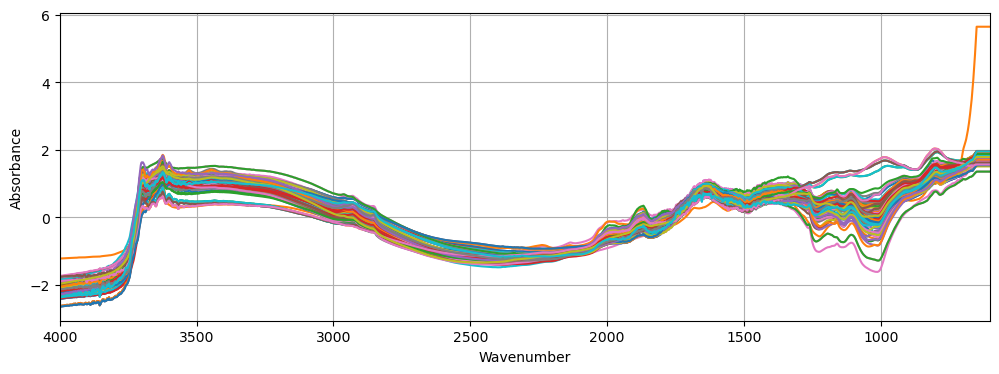

In [ ]:
plot_spectra(X, X_names, figsize=(12,4), sample=100)

In [ ]:
summary = {}
for i, analyte in enumerate(analytes):
    mask = ~np.isnan(y[:,i])
    skewness = skew(y[:,i][mask])
    print(80*'-')
    print(f'{analyte}')
    print(80*'-')
    print(f'skewness: {skewness}')

    mask_all = np.logical_and(mask, y[:,i] > 0)
    
    # KS on features
    #y_train, y_valid, X_train, X_valid = ks.train_test_split(y[:,i][mask_all].reshape(-1, 1), 
    #                                                         X[mask_all, :], test_size=0.2)
    # KS on target
    X_train, X_valid, y_train, y_valid = ks.train_test_split(X[mask_all, :], 
                                                             y[:,i][mask_all], test_size=0.2)
    
    print(f'# of training samples: {y_train.shape[0]}')
    print(f'# of valid samples: {y_valid.shape[0]}')
    
    if np.abs(skewness) > 0.5:
        y_train, y_valid = [np.log10(y) for y in [y_train, y_valid]]
    
    valid_scores = []
    for n_cpts in range(2, 30):
        m = Pipeline([
            ('snv', SNV()),
            #('derivative', TakeDerivative()),
            #('dropper', DropSpectralRegions(self.X_names, **self.pipeline_kwargs['dropper'])),
            ('model', PLSRegression(n_components=n_cpts))])

        m.fit(X_train, y_train)
        train_score = r2_score(y_train, m.predict(X_train))
        valid_score = r2_score(y_valid, m.predict(X_valid))
        valid_scores.append(valid_score)
        print(f'n_cpts: {n_cpts}, train_score: {train_score}, valid_score: {valid_score}')
    #print(f'max score: {np.max(np.array(valid_scores))}')
    summary[analyte] = np.max(np.array(valid_scores))

--------------------------------------------------------------------------------
kd_cs133
--------------------------------------------------------------------------------
skewness: 5.641400317833495
# of training samples: 112
# of valid samples: 29
n_cpts: 2, train_score: 0.14790035816806613, valid_score: -0.03754365237995794
n_cpts: 3, train_score: 0.21267427028865316, valid_score: -0.03330558558450125
n_cpts: 4, train_score: 0.2505013257238847, valid_score: 0.019437906863258192
n_cpts: 5, train_score: 0.2655167770002087, valid_score: 0.06510871741852098
n_cpts: 6, train_score: 0.2822621011884414, valid_score: 0.08590696359421235
n_cpts: 7, train_score: 0.2936370234502531, valid_score: 0.12592380817500892
n_cpts: 8, train_score: 0.3365745594022195, valid_score: 0.18887911567288607
n_cpts: 9, train_score: 0.40138233701426973, valid_score: 0.34264387489617
n_cpts: 10, train_score: 0.4619104680740188, valid_score: 0.39312845979574007
n_cpts: 11, train_score: 0.49608435220706293, valid_sc

n_cpts: 19, train_score: 0.6379737109405186, valid_score: 0.1914096180271484
n_cpts: 20, train_score: 0.6611822103261948, valid_score: 0.1753509097530498
n_cpts: 21, train_score: 0.6788244505300052, valid_score: 0.10298006411837257
n_cpts: 22, train_score: 0.6973965565503963, valid_score: 0.17307983161936902
n_cpts: 23, train_score: 0.7216952015753954, valid_score: 0.19685677119799416
n_cpts: 24, train_score: 0.7375003588693547, valid_score: 0.18152612730737994
n_cpts: 25, train_score: 0.7573668029157701, valid_score: 0.1135605593155149
n_cpts: 26, train_score: 0.7744542402112773, valid_score: 0.19453082270441802
n_cpts: 27, train_score: 0.7905094438832003, valid_score: 0.10896585453591112
n_cpts: 28, train_score: 0.8059098173320431, valid_score: -0.023628796081493597
n_cpts: 29, train_score: 0.8274592473158331, valid_score: -0.15355544546886346
--------------------------------------------------------------------------------
ex_cs137
----------------------------------------------------

# of training samples: 108
# of valid samples: 27
n_cpts: 2, train_score: 0.7076253234788468, valid_score: 0.8130433652401373
n_cpts: 3, train_score: 0.7327871119998887, valid_score: 0.838355868200729
n_cpts: 4, train_score: 0.7752931491192838, valid_score: 0.8665923879618147
n_cpts: 5, train_score: 0.7926090446327876, valid_score: 0.8782913929941697
n_cpts: 6, train_score: 0.8115134753952855, valid_score: 0.8911165596578667
n_cpts: 7, train_score: 0.8234023625656615, valid_score: 0.9078616033271814
n_cpts: 8, train_score: 0.8393879532463571, valid_score: 0.8995250080659305
n_cpts: 9, train_score: 0.8503320118128144, valid_score: 0.8982352418241065
n_cpts: 10, train_score: 0.8583783058576244, valid_score: 0.8954063201975617
n_cpts: 11, train_score: 0.8635753010995207, valid_score: 0.8926085540323333
n_cpts: 12, train_score: 0.8691174488179667, valid_score: 0.8807558156024289
n_cpts: 13, train_score: 0.8777376061568967, valid_score: 0.8964218519461364
n_cpts: 14, train_score: 0.88792070

n_cpts: 18, train_score: 0.862615778331787, valid_score: 0.7022730120135869
n_cpts: 19, train_score: 0.8807641797684512, valid_score: 0.7273798744090045
n_cpts: 20, train_score: 0.8910391369958102, valid_score: 0.7419860479996264
n_cpts: 21, train_score: 0.8988194052627826, valid_score: 0.7500396549304287
n_cpts: 22, train_score: 0.9056756458689261, valid_score: 0.7552822793493443
n_cpts: 23, train_score: 0.9113852365074556, valid_score: 0.744175930922415
n_cpts: 24, train_score: 0.9169725087042141, valid_score: 0.7522916052202808
n_cpts: 25, train_score: 0.9221822569765077, valid_score: 0.7566186932968355
n_cpts: 26, train_score: 0.9267202242881548, valid_score: 0.7433682545090916
n_cpts: 27, train_score: 0.9324554664354552, valid_score: 0.7239280316678087
n_cpts: 28, train_score: 0.9375610034109351, valid_score: 0.6978317339518293
n_cpts: 29, train_score: 0.9419150980601586, valid_score: 0.6965143619818246
------------------------------------------------------------------------------

In [ ]:
# KS in target
summary

{'kd_cs133': 0.6301412823531116,
 'ex_cs_total_cs_ratio': 0.2874807113190928,
 'cs137': 0.3314922436338681,
 'cs137_total': 0.32904348920045035,
 'ex_cs137': 0.09380383500229794,
 'ex_k2o': 0.26857888694083765,
 'ph': 0.6619984169268718,
 'c': 0.9078616033271814,
 'n': 0.8557924227856407,
 'c_n_ratio': 0.7081306441587658,
 'ex_mgo': 0.7566186932968355,
 'ex_cao': 0.6096964748845872,
 'cec': 0.658967575577236}

#### Augmented

In [ ]:
# Data loading
fname = Path('../../_data/seibersdorf-mirs-tabular/data-augmented.pkl')
X_train, y_train, X_valid, y_valid = load_pickle(fname)

In [ ]:
summary = {}
for i, analyte in enumerate(analytes):
    mask = ~np.isnan(y_train[:,i])
    skewness = skew(y_train[:,i][mask])
    print(80*'-')
    print(f'{analyte}')
    print(80*'-')
    print(f'skewness: {skewness}')

    # Filter out 0 and NaN values
    mask_train = np.logical_and(y_train[:,i] > 0, ~np.isnan(y_train[:,i]))
    mask_valid = np.logical_and(y_valid[:,i] > 0, ~np.isnan(y_valid[:,i]))
    
    
    X_train_clean, y_train_clean = X_train[mask_train,:], y_train[mask_train, i] 
    X_valid_clean, y_valid_clean = X_valid[mask_valid,:], y_valid[mask_valid, i] 
  
    print(f'# of training samples: {X_train_clean.shape[0]}, {y_train_clean.shape[0]}')
    print(f'# of valid samples: {y_valid_clean.shape[0]}')
    
    if np.abs(skewness) > 0.5:
        y_train_clean, y_valid_clean = [np.log10(y) for y in [y_train_clean, y_valid_clean]]

    valid_scores = []
    for n_cpts in range(2, 30):
        m = Pipeline([
            #('snv', SNV()),
            ('derivative', TakeDerivative()),
            #('dropper', DropSpectralRegions(self.X_names, **self.pipeline_kwargs['dropper'])),
            ('model', PLSRegression(n_components=n_cpts))])

        m.fit(X_train_clean, y_train_clean)
        train_score = r2_score(y_train_clean, m.predict(X_train_clean))
        valid_score = r2_score(y_valid_clean, m.predict(X_valid_clean))
        print(f'n_cpts: {n_cpts}, train_score: {train_score}, valid_score: {valid_score}')
        valid_scores.append(valid_score)
    summary[analyte] = np.max(np.array(valid_scores))

--------------------------------------------------------------------------------
kd_cs133
--------------------------------------------------------------------------------
skewness: 5.034500664275883
# of training samples: 2820, 2820
# of valid samples: 700
n_cpts: 2, train_score: 0.2956142483816444, valid_score: 0.1887874383090753
n_cpts: 3, train_score: 0.32750598006316745, valid_score: 0.14209107350094197
n_cpts: 4, train_score: 0.37728922785127395, valid_score: 0.22623066186605523
n_cpts: 5, train_score: 0.45869218313886273, valid_score: 0.28298218867647507
n_cpts: 6, train_score: 0.511507013760039, valid_score: 0.2655841929199072
n_cpts: 7, train_score: 0.5487660003100481, valid_score: 0.3184646021623321
n_cpts: 8, train_score: 0.5664531373170518, valid_score: 0.28920945566077283
n_cpts: 9, train_score: 0.6019298278599833, valid_score: 0.18250344393660256
n_cpts: 10, train_score: 0.6491267440291213, valid_score: 0.1327616729603106
n_cpts: 11, train_score: 0.6817458903415352, valid_

n_cpts: 11, train_score: 0.620246361175167, valid_score: 0.31386402330506236
n_cpts: 12, train_score: 0.6506800690357187, valid_score: 0.18254409876441424
n_cpts: 13, train_score: 0.7036186595545195, valid_score: 0.14495472798078346
n_cpts: 14, train_score: 0.7393887171750884, valid_score: 0.12189723951452036
n_cpts: 15, train_score: 0.7542477155168943, valid_score: 0.0999784492686947
n_cpts: 16, train_score: 0.7766046886068073, valid_score: 0.15964509058577303
n_cpts: 17, train_score: 0.811347141204148, valid_score: 0.14353655478699245
n_cpts: 18, train_score: 0.8267018092766318, valid_score: 0.16291321098281697
n_cpts: 19, train_score: 0.8351687214796284, valid_score: 0.18011701153174253
n_cpts: 20, train_score: 0.8455418379609687, valid_score: 0.14956059631076668
n_cpts: 21, train_score: 0.855612677156101, valid_score: 0.12851655009601803
n_cpts: 22, train_score: 0.8702205829188614, valid_score: 0.07260559601665384
n_cpts: 23, train_score: 0.8801034241502798, valid_score: 0.01427305

n_cpts: 24, train_score: 0.9575524979811044, valid_score: 0.5899559121411132
n_cpts: 25, train_score: 0.9606094265460294, valid_score: 0.5697793707640891
n_cpts: 26, train_score: 0.9647505959384981, valid_score: 0.5291264543839935
n_cpts: 27, train_score: 0.9674691678448303, valid_score: 0.5003364485031367
n_cpts: 28, train_score: 0.971313652356311, valid_score: 0.47796803021836265
n_cpts: 29, train_score: 0.9735065275944128, valid_score: 0.4719570228705172
--------------------------------------------------------------------------------
c
--------------------------------------------------------------------------------
skewness: 1.0779575228438951
# of training samples: 2720, 2720
# of valid samples: 660
n_cpts: 2, train_score: 0.7773766092607226, valid_score: 0.6760674891090016
n_cpts: 3, train_score: 0.8092518580558121, valid_score: 0.667864547824558
n_cpts: 4, train_score: 0.8423223794807729, valid_score: 0.7017880883932962
n_cpts: 5, train_score: 0.8656861541755521, valid_score: 0.7

n_cpts: 7, train_score: 0.7777866939532961, valid_score: 0.6138840137055832
n_cpts: 8, train_score: 0.7970592341012461, valid_score: 0.6312488737909224
n_cpts: 9, train_score: 0.8188615217679343, valid_score: 0.652126180729963
n_cpts: 10, train_score: 0.8424096329052894, valid_score: 0.6218047555176235
n_cpts: 11, train_score: 0.857046647502095, valid_score: 0.620976819645197
n_cpts: 12, train_score: 0.8718671661279686, valid_score: 0.6069162852727938
n_cpts: 13, train_score: 0.8853626472666196, valid_score: 0.6086015338921968
n_cpts: 14, train_score: 0.8927577888552978, valid_score: 0.596124242636187
n_cpts: 15, train_score: 0.9074578177428178, valid_score: 0.585631155328124
n_cpts: 16, train_score: 0.9136900287724807, valid_score: 0.6069172657496291
n_cpts: 17, train_score: 0.9280659457794731, valid_score: 0.600958864721644
n_cpts: 18, train_score: 0.9353242910143132, valid_score: 0.6023092530568406
n_cpts: 19, train_score: 0.9414409887014614, valid_score: 0.5875275730696932
n_cpts: 

In [ ]:
summary

{'kd_cs133': 0.3184646021623321,
 'ex_cs_total_cs_ratio': 0.5309745380447501,
 'cs137': 0.5058167898218315,
 'cs137_total': 0.4046382894065731,
 'ex_cs137': 0.4986447616454688,
 'ex_k2o': 0.307868787251651,
 'ph': 0.6555013786396309,
 'c': 0.720704166333706,
 'n': 0.7754999563709017,
 'c_n_ratio': 0.4242334433994873,
 'ex_mgo': 0.652126180729963,
 'ex_cao': 0.7795471675612241,
 'cec': 0.7742196349209908}

## Resnet + Transfer Learning

In [ ]:
path = Path('../../_data/seibersdorf-mirs')

In [ ]:
path.ls()

(#176) [Path('../../_data/seibersdorf-mirs/135'),Path('../../_data/seibersdorf-mirs/95'),Path('../../_data/seibersdorf-mirs/66'),Path('../../_data/seibersdorf-mirs/104'),Path('../../_data/seibersdorf-mirs/68'),Path('../../_data/seibersdorf-mirs/103'),Path('../../_data/seibersdorf-mirs/168'),Path('../../_data/seibersdorf-mirs/157'),Path('../../_data/seibersdorf-mirs/150'),Path('../../_data/seibersdorf-mirs/159')...]

In [ ]:
#analytes = ['kd_cs133', 'ex_cs_total_cs_ratio', 'cs137', 'cs137_total', 
#            'ex_cs137', 'ex_k2o', 'ph', 'c', 'n', 'c_n_ratio', 'ex_mgo',
#            'ex_cao', 'cec']
#analyte = 'ex_k2o'
analyte = 'cec'

In [ ]:
from spanda.data.transforms.kssl import Spectra

In [ ]:
@Transform
def plateau(x:Spectra) -> Spectra:
    val = x[:,1675]
    x[:,1675:] = val
    return x

In [ ]:
#x_tfms = [get_spectra_files, to_spectra, rand_w_avg, snv]
x_tfms = [get_spectra_files, to_spectra, avg, snv]
#y_tfms = [AnalytesTfm(analytes=[analyte]), lambda x: x/10, torch.log10]
#y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]
y_tfms = [AnalytesTfm(analytes=[analyte])]

In [ ]:
splits = RandomSplitter(valid_pct=0.2, seed=41)(path.ls())
dsets = Datasets(path.ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=16, num_workers=8, drop_last=False)
#dls.train.one_batch()[0][0]
#dls.train.one_batch()[1]

In [ ]:
# Pre-trained model
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
#weights_paths = '../../_data/models/xresnet18-k-ex-snv-lr-5e-4-r2-0-828.pth'
#xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
#model.load_state_dict(xresnet_dict['model'])

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())
#learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=PearsonCorrCoef())

In [ ]:
#learn.freeze_to(-1)

SuggestedLRs(valley=0.004365158267319202)

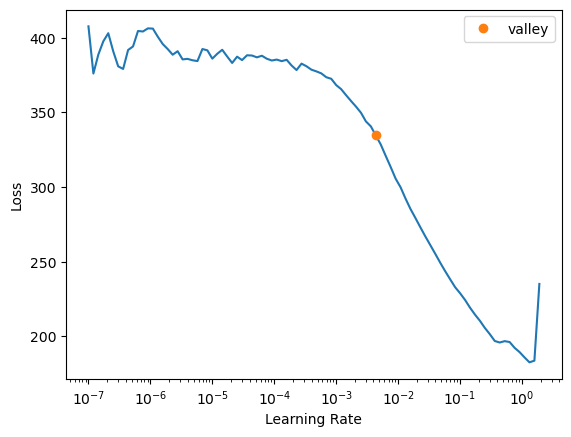

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, 4e-3)

epoch,train_loss,valid_loss,r2_score,time
0,28.375093,47.061592,0.144546,00:10
1,29.372705,52.447330,0.046648,00:10
2,29.115891,44.903656,0.183771,00:10
3,29.703041,61.128357,-0.111150,00:11
4,29.523506,68.620377,-0.247335,00:10
5,29.791254,52.177109,0.051559,00:12
6,29.701992,46.274677,0.158850,00:10
7,30.138176,54.685246,0.005968,00:11
8,29.932650,57.694504,-0.048732,00:11
9,30.066675,93.262825,-0.695269,00:10


In [ ]:
np.sqrt(0.06)

0.2449489742783178

In [ ]:
# Eval on Valid
#x_tfms = [get_spectra_files, to_spectra, rand_w_avg, snv]
x_tfms = [get_spectra_files, to_spectra, avg, snv]
y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]

#x_tfms = [get_spectra_files, to_spectra, avg, plateau, snv]
#y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]

splits = RandomSplitter(valid_pct=0.2, seed=41)(path.ls())
dsets = Datasets(path.ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=256, drop_last=True, shuffle=False)

#dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms], splits=splits)
#dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

y_train_hat = learn.model(dls.valid.one_batch()[0]).detach().numpy()
y_train_true = dls.valid.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

0.16615733402191213

In [ ]:
((y_train_true - y_train_hat)**2).mean()

0.021605065

In [ ]:
np.mean(y_train_true)

1.2964761

In [ ]:
np.sum((y_train_hat - np.mean(y_train_true))**2)

0.1035327

In [ ]:
np.sum((y_train_hat - y_train_true)**2)

0.75617725

In [ ]:
import matplotlib.pyplot as plt

<matplotlib.collections.PathCollection>

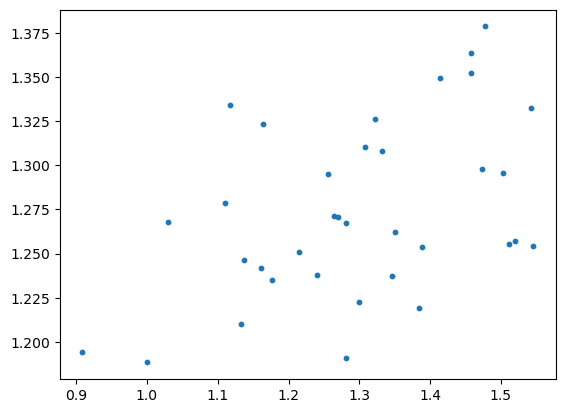

In [ ]:
plt.scatter(y_train_true, y_train_hat, s=10)

In [ ]:
def get_nb_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
get_nb_params(learn.model) / 1e6

3.853409